# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
df_cancer = data.frame
df_cancer.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df_cancer.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

# Analisis del Dataset

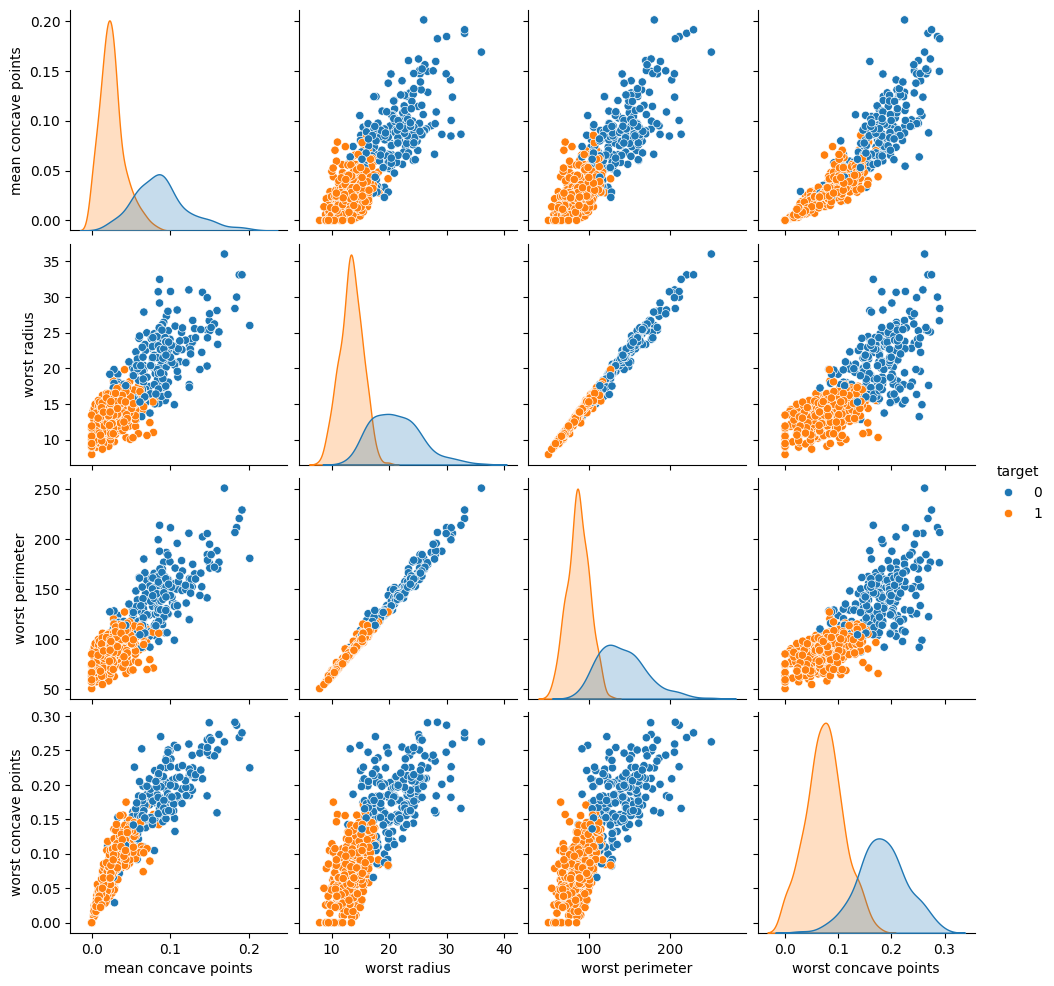

In [4]:
correlation = df_cancer.corr()
threshold = 0.75
filter = np.abs(correlation["target"]) > threshold
correlation_features = correlation.columns[filter].tolist()
sns.pairplot(df_cancer[correlation_features], diag_kind = "kde",  hue="target")
plt.show()

# Preprocesamiento de datos

In [5]:
# Hacemos el Split 70-30 para train-test
X = df_cancer.drop(columns="target")
y = df_cancer["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [6]:
#Pipeline LogisticRegression basico
pl_logreg = Pipeline([
    ("selector", ColumnTransformer([("selector", "passthrough", ['mean concave points', 'worst radius', 'worst perimeter', 'worst concave points'])], remainder="drop")),
    ('classifier', LogisticRegression())
])
pl_logreg.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['mean concave points',
                                                   'worst radius',
                                                   'worst perimeter',
                                                   'worst concave points'])])),
                ('classifier', LogisticRegression())])

In [7]:
y_pred_lg = pl_logreg.predict(X_test)

# Comparamos por Curva ROC

In [8]:
def graficarCurvaRoc( y_pred, model ):
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
  auc = metrics.roc_auc_score(y_test, y_pred)
  # Graficamos
  plt.plot(fpr,tpr,label= model +" AUC="+str(round(auc,4))) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)
  return auc

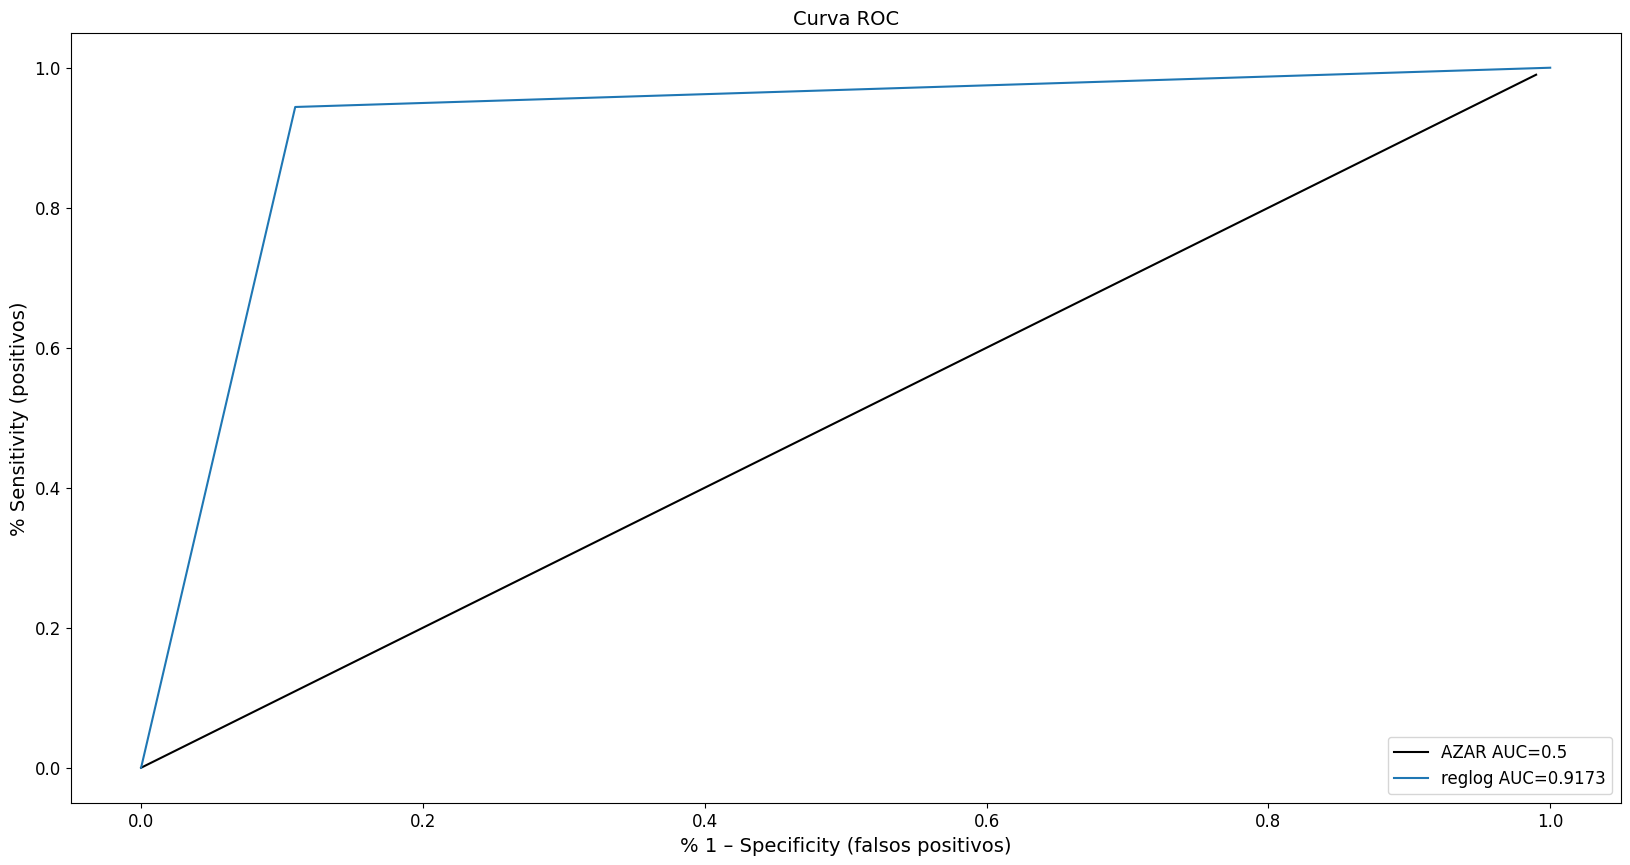

In [9]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'reglog':y_pred_lg}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

In [10]:
areas.sort_values('auc', ascending=False)

,model,auc
0,reglog,0.917275


# Ejercicio

### Analisis
- Averiguar distribución de la variable target.
- Graficar Heatmap de la correlacion entre variables numericas y el target.

### Evaluacion de Modelos
- Crear Pipelines para otros modelos (arbol, bayes y knn )
- Comparar los resultados por sus curvas ROC
- ¿Mejoran los modelos con más columnas? (modificando el step de selector del pipeline)
- ¿Mejoran los modelos escalando las variables? (agregando un step de escalado a los pipelines)

### Fine-tunning
- Elegir uno de los modelos y optimizarlo con gridsearchCV

## Analisis

Averiguar distribución de la variable target.

In [17]:
df_cancer['target'].value_counts(normalize=True) * 100

,proportion
target,
1,62.741652
0,37.258348


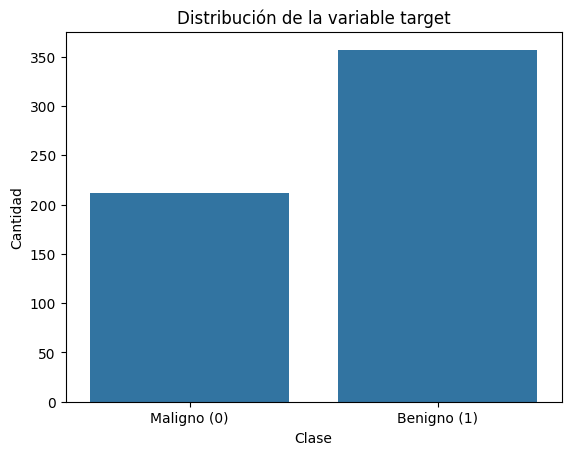

In [18]:
sns.countplot(x='target', data=df_cancer)
plt.title('Distribución de la variable target')
plt.xticks([0, 1], ['Maligno (0)', 'Benigno (1)'])
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

Graficar Heatmap de la correlacion entre variables numericas y el target

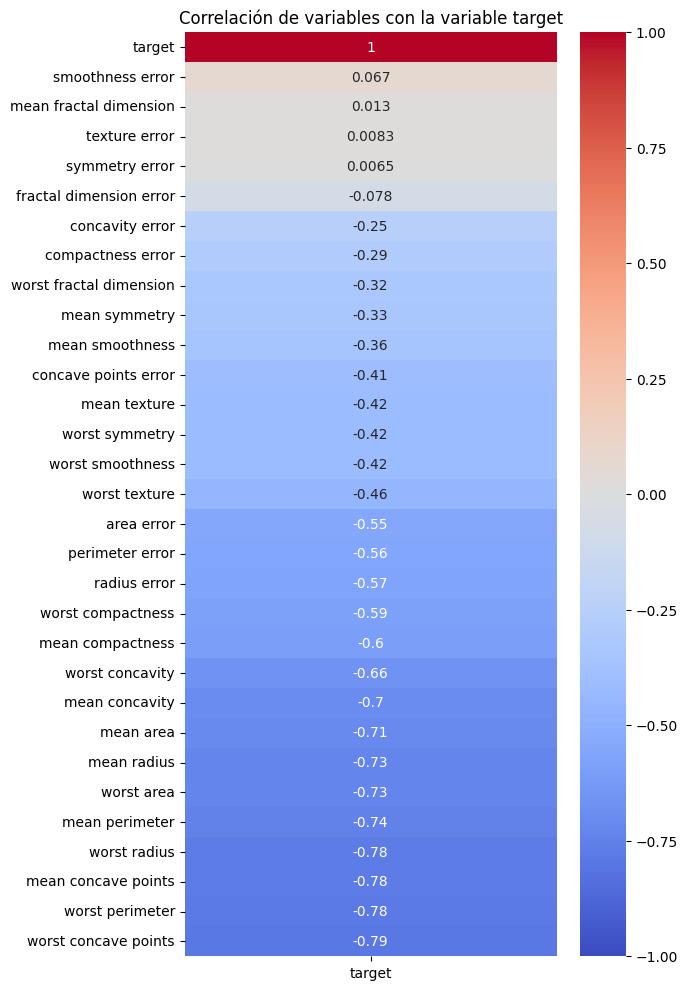

In [19]:
# Calcular la matriz de correlación
correlation_matrix = df_cancer.corr(numeric_only=True)

# Seleccionar solo las correlaciones con 'target'
cor_target = correlation_matrix[['target']].sort_values(by='target', ascending=False)

# Graficar el heatmap
plt.figure(figsize=(6, 12))
sns.heatmap(cor_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación de variables con la variable target')
plt.show()

## Evaluacion de Modelos

Crear Pipelines para otros modelos (arbol, bayes y knn )

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Pipeline Árbol de Decisión
pl_tree = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", ['mean concave points', 'worst radius', 'worst perimeter', 'worst concave points'])
    ], remainder="drop")),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Entrenar
pl_tree.fit(X_train, y_train)
y_pred_tree = pl_tree.predict(X_test)

In [21]:
from sklearn.naive_bayes import GaussianNB

# Pipeline Naive Bayes
pl_nb = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", ['mean concave points', 'worst radius', 'worst perimeter', 'worst concave points'])
    ], remainder="drop")),
    ("classifier", GaussianNB())
])

# Entrenar
pl_nb.fit(X_train, y_train)
y_pred_nb = pl_nb.predict(X_test)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Pipeline KNN
pl_knn = Pipeline([
    ("selector", ColumnTransformer([
        ("selector", "passthrough", ['mean concave points', 'worst radius', 'worst perimeter', 'worst concave points'])
    ], remainder="drop")),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

# Entrenar
pl_knn.fit(X_train, y_train)
y_pred_knn = pl_knn.predict(X_test)

Comparar los resultados por sus curvas ROC

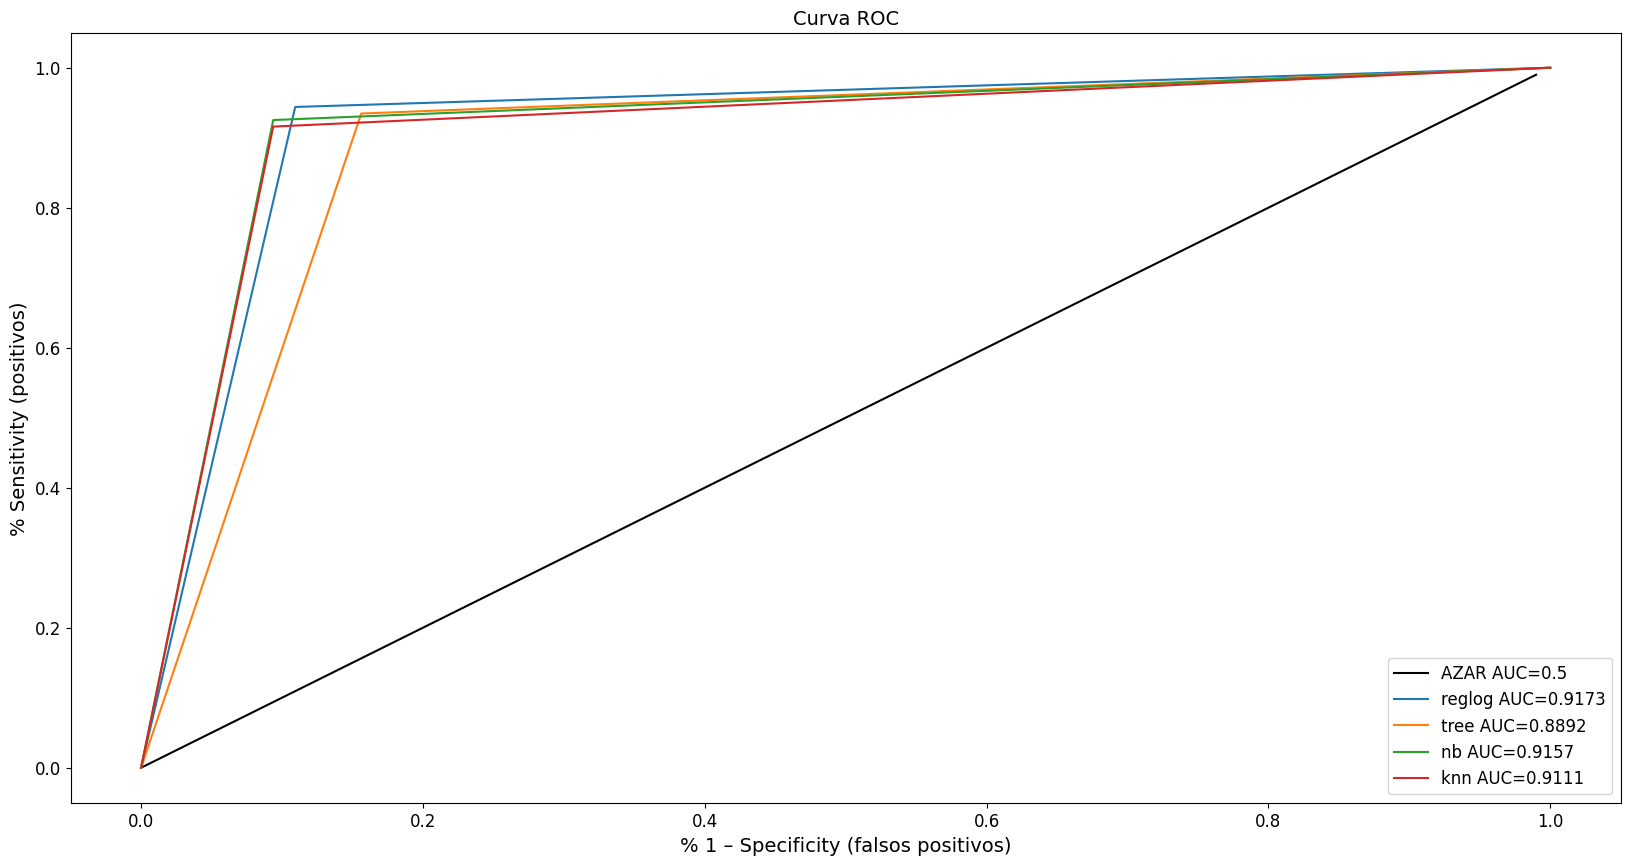

In [26]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'reglog':y_pred_lg, 'tree': y_pred_tree, 'nb': y_pred_nb, 'knn': y_pred_knn}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

¿Mejoran los modelos con más columnas? (modificando el step de selector del pipeline)

In [52]:
# Matriz de correlación
corr_matrix = df_cancer.corr()
# Parte superior para no repetir pares ni diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Defino umbral para correlación alta (en valor absoluto)
threshold = 0.95
# Busco pares con correlación absoluta >= threshold
high_corr = [(col, row, corr_val) for col in upper.columns for row, corr_val in upper[col].items() if abs(corr_val) >= threshold]

print("Pares de variables con correlación alta (>= 0.95):")
for c1, c2, val in high_corr:
    print(f"{c1} y {c2} --> correlación: {val:.4f}")

# Variables a eliminar (segunda de cada par)
vars_to_drop = [pair[1] for pair in high_corr]

print("\nVariables a eliminar por alta correlación:")
print(vars_to_drop)

# Nuevo dataset sin variables redundantes
df_cancer_reduced = df_cancer.drop(columns=vars_to_drop)

print("\nColumnas después de eliminar variables redundantes:")
print(df_cancer_reduced.columns)

Pares de variables con correlación alta (>= 0.95):
mean perimeter y mean radius --> correlación: 0.9979
mean area y mean radius --> correlación: 0.9874
mean area y mean perimeter --> correlación: 0.9865
perimeter error y radius error --> correlación: 0.9728
area error y radius error --> correlación: 0.9518
worst radius y mean radius --> correlación: 0.9695
worst radius y mean perimeter --> correlación: 0.9695
worst radius y mean area --> correlación: 0.9627
worst perimeter y mean radius --> correlación: 0.9651
worst perimeter y mean perimeter --> correlación: 0.9704
worst perimeter y mean area --> correlación: 0.9591
worst perimeter y worst radius --> correlación: 0.9937
worst area y mean area --> correlación: 0.9592
worst area y worst radius --> correlación: 0.9840
worst area y worst perimeter --> correlación: 0.9776

Variables a eliminar por alta correlación:
['mean radius', 'mean radius', 'mean perimeter', 'radius error', 'radius error', 'mean radius', 'mean perimeter', 'mean area',

Sacar redundantes no hizo que funcione mejor 😲

In [74]:
corr = df_cancer.corr()
corr_target = corr['target'].abs().sort_values(ascending=False)

# Tomo las top 4 variables (excluyendo la primera que es 'target' mismo)
cols_seleccionadas = corr_target.index[1:6].tolist()

print("Columnas seleccionadas para el pipeline:")
print(cols_seleccionadas)

# Defino el selector para el pipeline
selector = ColumnTransformer([
    ("selector", "passthrough", cols_seleccionadas)
], remainder="drop")

Columnas seleccionadas para el pipeline:
['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter']


In [75]:
# Pipeline regresión logística
pl_logreg = Pipeline([
    ("selector", selector),
    ("classifier", LogisticRegression())
])
pl_logreg.fit(X_train, y_train)
y_pred_lg = pl_logreg.predict(X_test)
# ----------------------------------------------
# Pipeline KNN
pl_knn = Pipeline([
    ("selector", selector),
    ("classifier", KNeighborsClassifier())
])
# Entrenar
pl_knn.fit(X_train, y_train)
y_pred_knn = pl_knn.predict(X_test)
# ----------------------------------------------
# Pipeline Naive Bayes
pl_nb = Pipeline([
    ("selector", selector),
    ("classifier", GaussianNB())
])
# Entrenar
pl_nb.fit(X_train, y_train)
y_pred_nb = pl_nb.predict(X_test)
# ----------------------------------------------
# Pipeline árbol de decisión
pl_tree = Pipeline([
    ("selector", selector),
    ("classifier", DecisionTreeClassifier())
])
# Entrenar
pl_tree.fit(X_train, y_train)
y_pred_tree = pl_tree.predict(X_test)

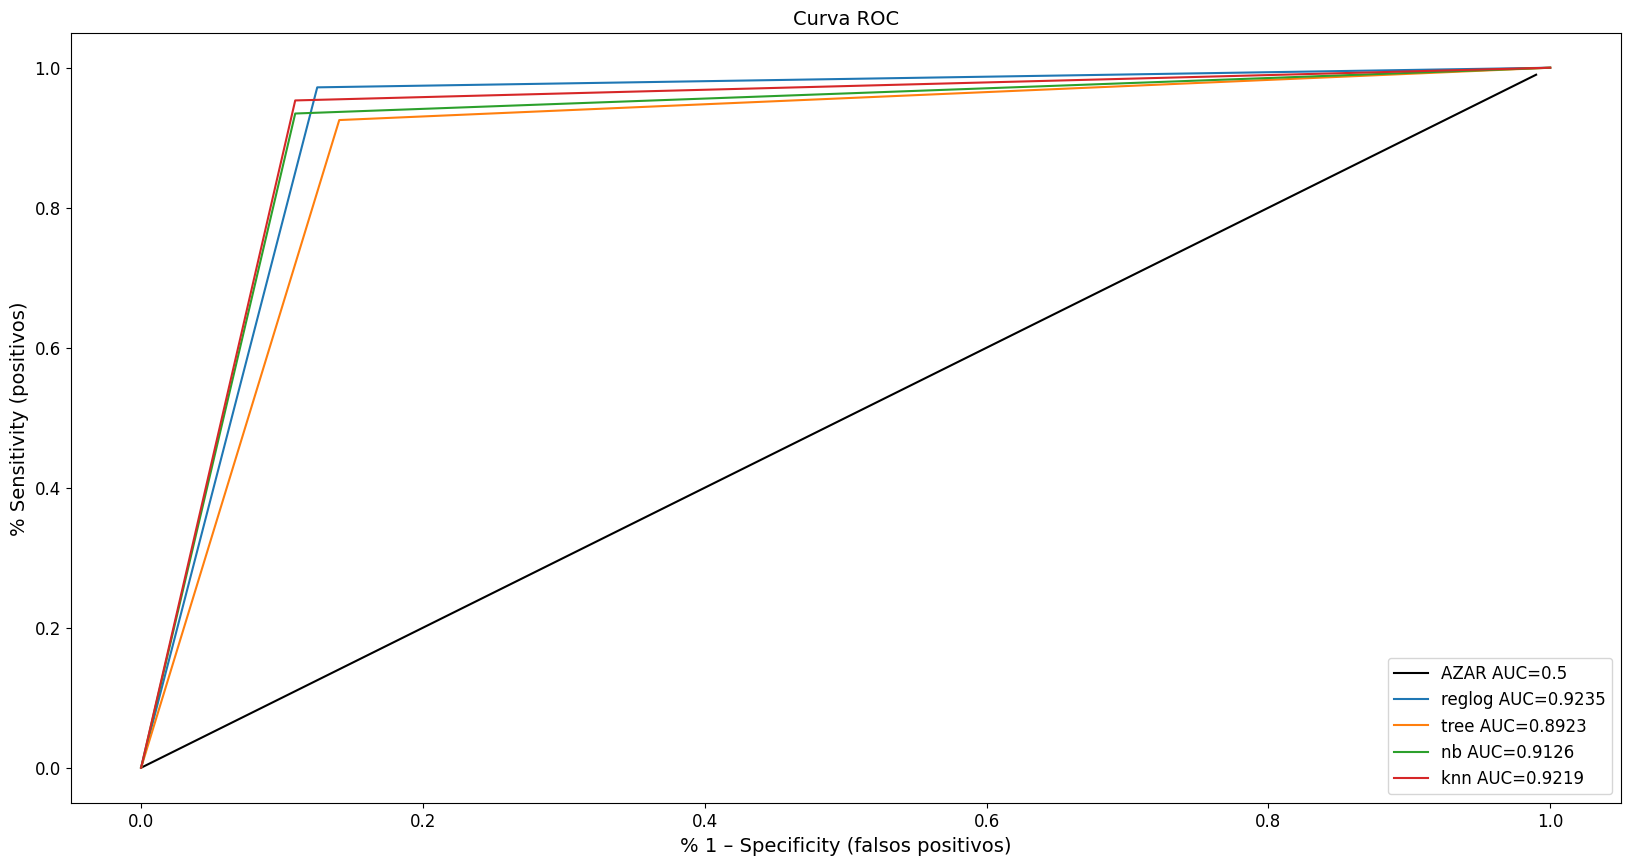

In [76]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'reglog':y_pred_lg, 'tree': y_pred_tree, 'nb': y_pred_nb, 'knn': y_pred_knn}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

Agregando una variable más, mejoraron los numeros generales.

¿Mejoran los modelos escalando las variables? (agregando un step de escalado a los pipelines)

In [94]:
# Defino escalador
scaler = StandardScaler()

In [95]:
corr = df_cancer.corr()
corr_target = corr['target'].abs().sort_values(ascending=False)

# Tomo las top 4 variables (excluyendo la primera que es 'target' mismo)
cols_seleccionadas = corr_target.index[1:6].tolist()

print("Columnas seleccionadas para el pipeline:")
print(cols_seleccionadas)

# Defino el selector para el pipeline
selector = ColumnTransformer([
    ("selector", "passthrough", cols_seleccionadas)
], remainder="drop")

Columnas seleccionadas para el pipeline:
['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter']


In [96]:
# Pipeline regresión logística
pl_logreg = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", LogisticRegression())
])
pl_logreg.fit(X_train, y_train)
y_pred_lg = pl_logreg.predict(X_test)
# ----------------------------------------------
# Pipeline KNN
pl_knn = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", KNeighborsClassifier())
])
# Entrenar
pl_knn.fit(X_train, y_train)
y_pred_knn = pl_knn.predict(X_test)
# ----------------------------------------------
# Pipeline Naive Bayes
pl_nb = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", GaussianNB())
])
# Entrenar
pl_nb.fit(X_train, y_train)
y_pred_nb = pl_nb.predict(X_test)
# ----------------------------------------------
# Pipeline árbol de decisión
pl_tree = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", DecisionTreeClassifier())
])
# Entrenar
pl_tree.fit(X_train, y_train)
y_pred_tree = pl_tree.predict(X_test)

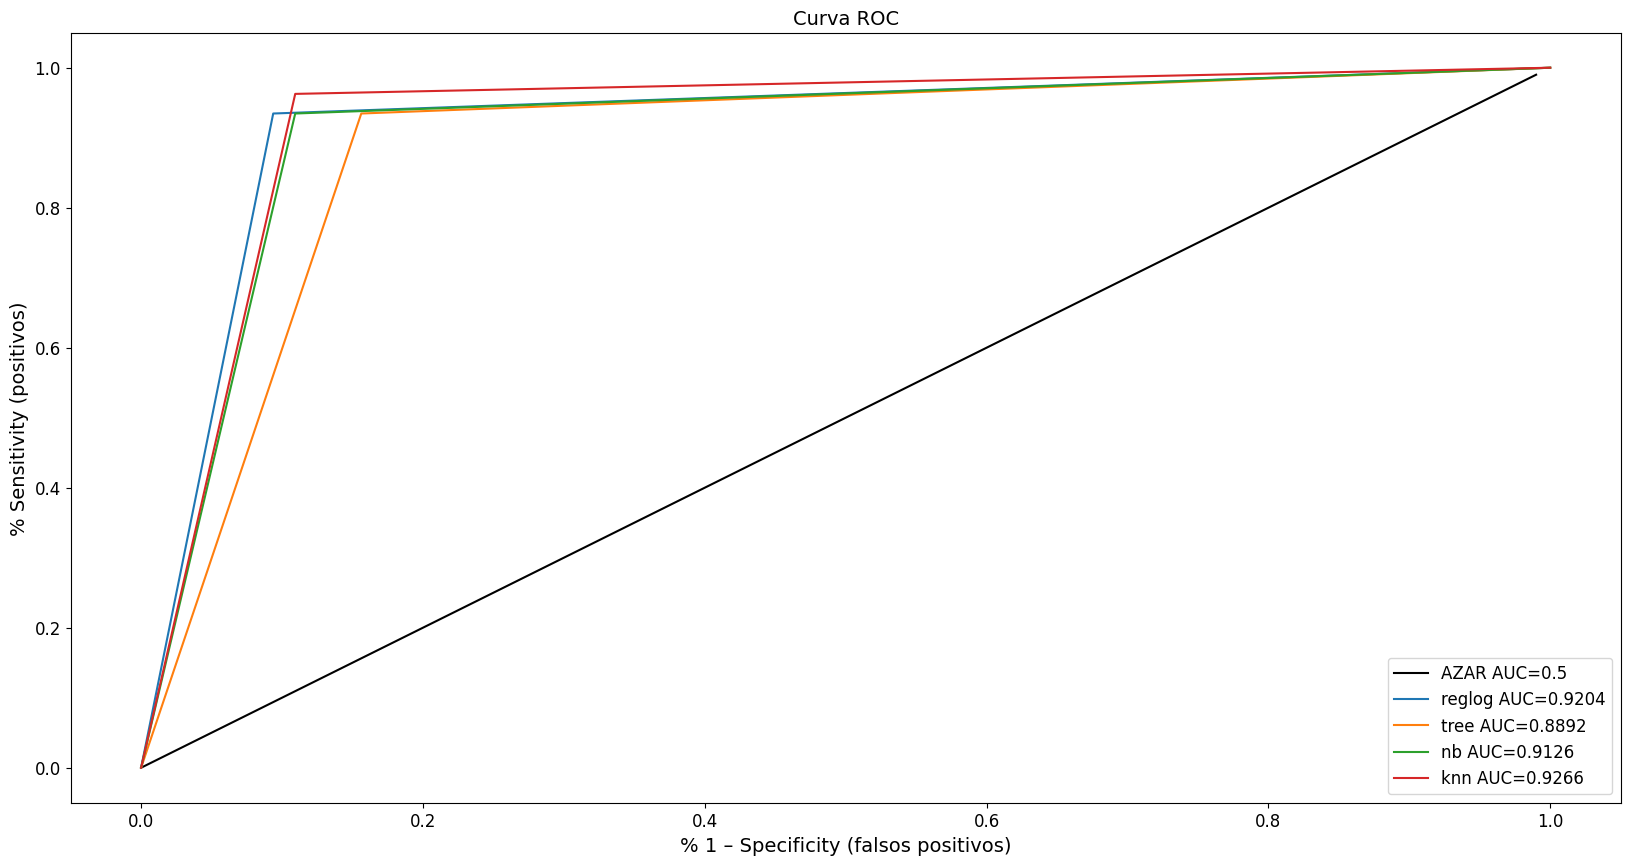

In [97]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'reglog':y_pred_lg, 'tree': y_pred_tree, 'nb': y_pred_nb, 'knn': y_pred_knn}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

Escalando las variables, los resultados empeoran.

Pero si escalo las variables y uso el dataset (que hice antes) sin las que tienen correlación mayor a 0.95 funciona mejor que todas las veces 😊

In [112]:
corr = df_cancer_reduced.corr()
corr_target = corr['target'].abs().sort_values(ascending=False)

# Tomo las top 4 variables (excluyendo la primera que es 'target' mismo)
cols_seleccionadas = corr_target.index[1:6].tolist()

print("Columnas seleccionadas para el pipeline:")
print(cols_seleccionadas)

# Defino el selector para el pipeline
selector = ColumnTransformer([
    ("selector", "passthrough", cols_seleccionadas)
], remainder="drop")

Columnas seleccionadas para el pipeline:
['worst concave points', 'mean concave points', 'worst area', 'mean concavity', 'worst concavity']


In [114]:
# Pipeline regresión logística
pl_logreg = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", LogisticRegression())
])
pl_logreg.fit(X_train, y_train)
y_pred_lg = pl_logreg.predict(X_test)
# ----------------------------------------------
# Pipeline KNN
pl_knn = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", KNeighborsClassifier())
])
# Entrenar
pl_knn.fit(X_train, y_train)
y_pred_knn = pl_knn.predict(X_test)
# ----------------------------------------------
# Pipeline Naive Bayes
pl_nb = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", GaussianNB())
])
# Entrenar
pl_nb.fit(X_train, y_train)
y_pred_nb = pl_nb.predict(X_test)
# ----------------------------------------------
# Pipeline árbol de decisión
pl_tree = Pipeline([
    ("selector", selector),
    ('scaler', scaler),
    ("classifier", DecisionTreeClassifier())
])
# Entrenar
pl_tree.fit(X_train, y_train)
y_pred_tree = pl_tree.predict(X_test)

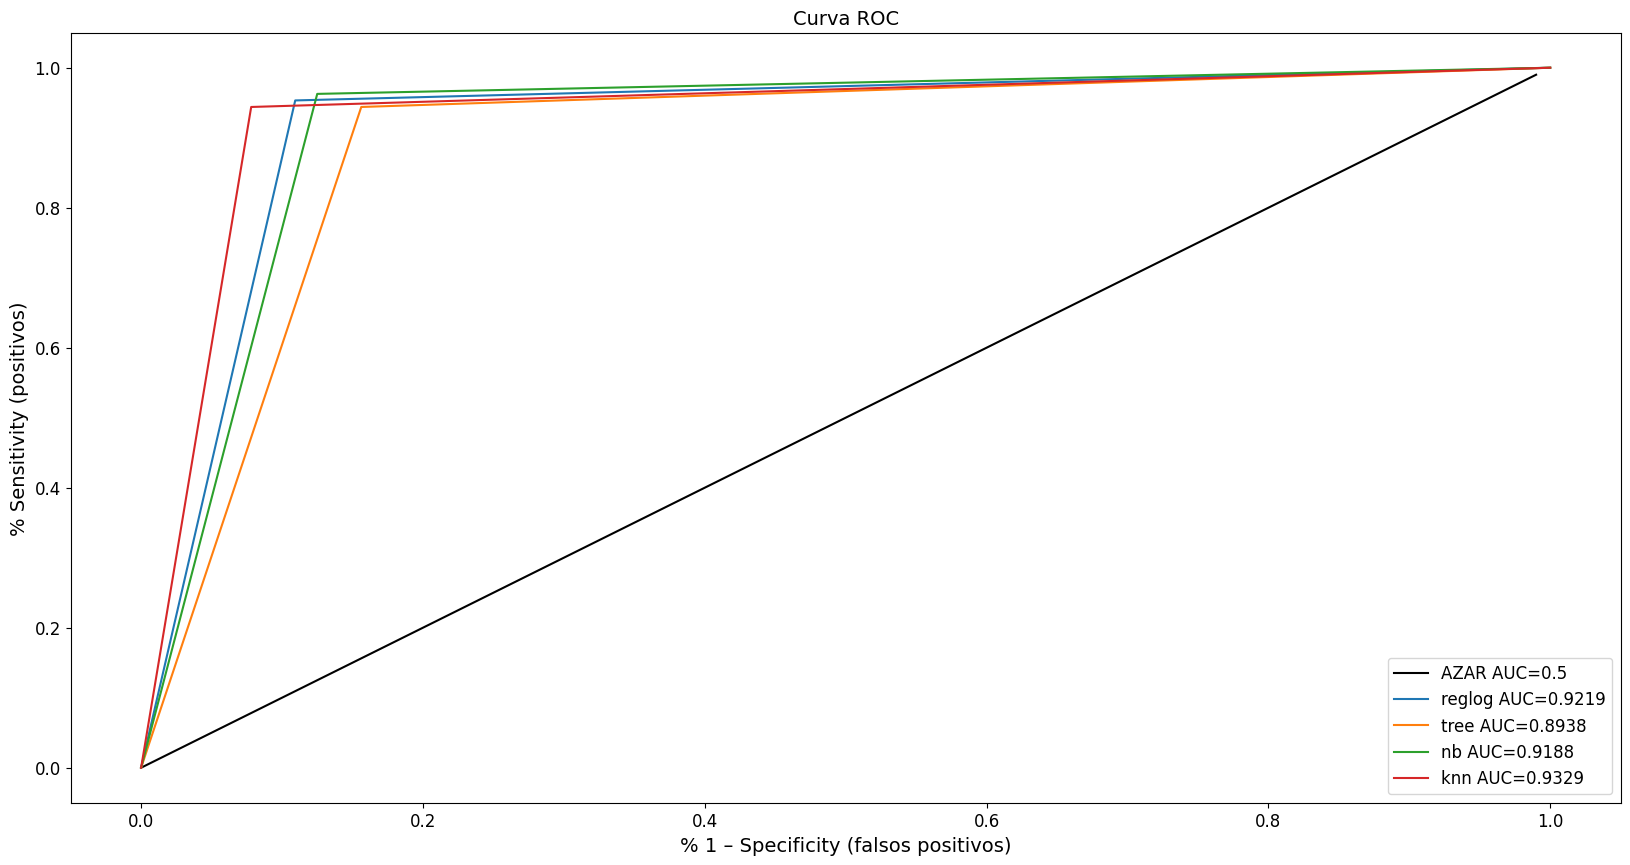

In [115]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'reglog':y_pred_lg, 'tree': y_pred_tree, 'nb': y_pred_nb, 'knn': y_pred_knn}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

## Fine-tunning

Elegir uno de los modelos y optimizarlo con gridsearchCV

In [121]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],      # cantidad de vecinos
    'classifier__weights': ['uniform', 'distance'],   # peso de los vecinos
    'classifier__metric': ['euclidean', 'manhattan']  # métricas de distancia
}

grid_search_knn = GridSearchCV(pl_knn, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search_knn.fit(X_train, y_train)

print("Mejores parámetros KNN:", grid_search_knn.best_params_)
print("Mejor AUC CV KNN:", grid_search_knn.best_score_)

# Evaluación en test
y_pred_knn_best = grid_search_knn.predict(X_test)
from sklearn.metrics import roc_auc_score
print("AUC test KNN:", roc_auc_score(y_test, y_pred_knn_best))

Mejores parámetros KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Mejor AUC CV KNN: 0.9843402298850574
AUC test KNN: 0.9266209112149533


In [122]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # regularización
    'classifier__penalty': ['l2'],  # sólo l2 porque l1 requiere solver distinto
    'classifier__solver': ['lbfgs', 'saga']
}

grid_search = GridSearchCV(pl_logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Entreno con los datos de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor AUC en CV:", grid_search.best_score_)

# Evaluación final en test
y_pred_best = grid_search.predict(X_test)
from sklearn.metrics import roc_auc_score
print("AUC en test:", roc_auc_score(y_test, y_pred_best))


Mejores parámetros: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Mejor AUC en CV: 0.9915724137931035
AUC en test: 0.9219480140186915


In [123]:
param_grid_nb = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid_search_nb = GridSearchCV(pl_nb, param_grid_nb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

print("Mejores parámetros NB:", grid_search_nb.best_params_)
print("Mejor AUC CV NB:", grid_search_nb.best_score_)

y_pred_nb_best = grid_search_nb.predict(X_test)
print("AUC test NB:", roc_auc_score(y_test, y_pred_nb_best))

Mejores parámetros NB: {'classifier__var_smoothing': 1e-09}
Mejor AUC CV NB: 0.978735632183908
AUC test NB: 0.9188084112149533


In [124]:
param_grid_tree = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_tree = GridSearchCV(pl_tree, param_grid_tree, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_tree.fit(X_train, y_train)

print("Mejores parámetros Árbol:", grid_search_tree.best_params_)
print("Mejor AUC CV Árbol:", grid_search_tree.best_score_)

y_pred_tree_best = grid_search_tree.predict(X_test)
print("AUC test Árbol:", roc_auc_score(y_test, y_pred_tree_best))

Mejores parámetros Árbol: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10}
Mejor AUC CV Árbol: 0.9757517241379311
AUC test Árbol: 0.9047897196261683


KNN termina siendo el mejor para clasificar en este caso.